# IDADM - Task 2
## Imports

In [34]:
import pandas as pd
import numpy as np
import ast

from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

## Data Preprocessing

In [3]:
lol_data = pd.read_csv('dataset/LeagueofLegends.csv')
lol_data

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,redMiddleChamp,goldredMiddle,redADC,redADCChamp,goldredADC,redSupport,redSupportChamp,goldredSupport,redBans,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,Fizz,"[475, 475, 552, 842, 1178, 1378, 1635, 1949, 2...",Sneaky,Sivir,"[475, 475, 532, 762, 1097, 1469, 1726, 2112, 2...",LemonNation,Thresh,"[515, 515, 577, 722, 911, 1042, 1194, 1370, 14...","['Tristana', 'Leblanc', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,Azir,"[475, 475, 552, 786, 1097, 1389, 1660, 1955, 2...",CoreJJ,Corki,"[475, 475, 532, 868, 1220, 1445, 1732, 1979, 2...",KiWiKiD,Annie,"[515, 515, 583, 752, 900, 1066, 1236, 1417, 15...","['RekSai', 'Janna', 'Leblanc']",http://matchhistory.na.leagueoflegends.com/en/...
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,Azir,"[475, 475, 533, 801, 1006, 1233, 1385, 1720, 1...",Cop,Corki,"[475, 475, 533, 781, 1085, 1398, 1782, 1957, 2...",BunnyFuFuu,Janna,"[515, 515, 584, 721, 858, 1002, 1168, 1303, 14...","['Leblanc', 'Zed', 'RekSai']",http://matchhistory.na.leagueoflegends.com/en/...
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,Lulu,"[475, 475, 532, 771, 1046, 1288, 1534, 1776, 2...",KEITH,KogMaw,"[475, 475, 532, 766, 1161, 1438, 1776, 1936, 2...",Xpecial,Janna,"[515, 515, 583, 721, 870, 1059, 1205, 1342, 15...","['RekSai', 'Rumble', 'LeeSin']",http://matchhistory.na.leagueoflegends.com/en/...
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,Lulu,"[475, 475, 532, 807, 1042, 1338, 1646, 1951, 2...",Maplestreet8,Corki,"[475, 475, 532, 792, 1187, 1488, 1832, 2136, 2...",Dodo8,Annie,"[475, 475, 538, 671, 817, 948, 1104, 1240, 136...","['Rumble', 'Sivir', 'Rengar']",http://matchhistory.na.leagueoflegends.com/en/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7615,TCL,2018,Spring,Season,YC,0,1,SUP,34,"[0, 0, -18, -95, 45, -87, -117, 199, 126, 92, ...",...,Veigar,"[500, 500, 632, 982, 1258, 1667, 2060, 2390, 2...",Zeitnot,Xayah,"[500, 500, 564, 1027, 1320, 1727, 1963, 2276, ...",SnowFlower,Rakan,"[500, 500, 566, 801, 1004, 1234, 1463, 1674, 1...","['Ornn', 'Kalista', 'Ryze', 'Alistar', 'Shen']",https://matchhistory.euw.leagueoflegends.com/e...
7616,TCL,2018,Spring,Season,GAL,0,1,DP,39,"[0, 0, -86, -39, -207, -349, -60, -140, 187, -...",...,Ryze,"[500, 500, 612, 1000, 1193, 1626, 1979, 2318, ...",Ruvelius,Caitlyn,"[500, 500, 621, 977, 1420, 1809, 2047, 2413, 2...",Japone,Braum,"[500, 500, 587, 790, 1107, 1335, 1472, 1616, 1...","['Zoe', 'KogMaw', 'JarvanIV', 'Ornn', 'Rengar']",https://matchhistory.euw.leagueoflegends.com/e...
7617,OPL,2018,Spring,Season,SIN,0,1,DW,24,"[0, -8, -6, 116, 103, -92, -470, -958, -1998, ...",...,Malzahar,"[500, 500, 615, 903, 1225, 1617, 1976, 2304, 2...",k1ng,Ezreal,"[500, 508, 592, 986, 1400, 1753, 2196, 2538, 3...",Cupcake,Taric,"[500, 500, 585, 770, 976, 1222, 1446, 1627, 19...","['Azir', 'Kalista', 'Braum', 'Maokai', 'Alistar']",https://matchhistory.na.leagueoflegends.com/en...
7618,OPL,2018,Spring,Season,LGC,1,0,TTC,35,"[0, 0, -97, 33, 351, 284, 299, 263, 403, 623, ...",...,Veigar,"[500, 500, 561, 931, 1223, 1631, 1987, 2315, 2...",Low,Sivir,"[500, 500, 634, 930, 1304, 1691, 2042, 2384, 2...",Tilting,Janna,"[500, 500, 592, 788, 1006, 1251, 1490, 1704, 1...","['Kalista', 'Galio', 'Gnar', 'Jayce', 'Sejuani']",https://matchhistory.na.leagueoflegends.com/en...


In [4]:
Y = lol_data['bResult'].to_numpy()
X = []
n_features = 13
for _, row in tqdm(lol_data.iterrows(), desc='Extracting data...', ncols=150):
    # Preprocess Data
    length = row['gamelength']
    X_i = np.zeros((length, n_features))

    X_i[:, 0] = ast.literal_eval(row['golddiff'])

    for team in ['b', 'r']:

        base = 0 if team == 'b' else 6

        kills_minutes = [int(kill[0]) for kill in ast.literal_eval(row[team + 'Kills'])]
        kills_i = [np.count_nonzero(np.array(kills_minutes) == minute) for minute in range(length)]
        X_i[:, base + 1] = kills_i

        towers_minutes = [(int(towers[0]), towers[2]) for towers in ast.literal_eval(row[team + 'Towers'])]
        towers_i = [0]

        for minute in range(1, length):
            score = towers_i[-1]
            for tower_minute in towers_minutes:
                if tower_minute[0] == minute:
                    if tower_minute[1] == 'NEXUS_TURRET':
                        score += 4
                    elif tower_minute[1] == 'BASE_TURRET':
                        score += 3
                    elif tower_minute[1] == 'INNER_TURRET':
                        score += 2
                    elif tower_minute[1] == 'OUTER_TURRET':
                        score += 1
            towers_i.append(score)
        X_i[:, base + 2] = towers_i

        inhibs_minutes = [int(inhib[0]) for inhib in ast.literal_eval(row[team + 'Inhibs'])]
        inhibs_i = [np.count_nonzero(np.array(inhibs_minutes) == minute) for minute in range(length)]
        X_i[:, base + 3] = inhibs_i

        dragons_minutes = [int(dragons[0]) for dragons in ast.literal_eval(row[team + 'Dragons'])]
        dragons_i = [np.count_nonzero(np.array(dragons_minutes) == minute) for minute in range(length)]
        X_i[:, base + 4] = np.cumsum(dragons_i)

        baron_minutes = [int(baron[0]) for baron in ast.literal_eval(row[team + 'Barons'])]
        baron_i = np.array([np.count_nonzero(np.array(baron_minutes) == minute) for minute in range(length)])
        baron_idx = np.where(baron_i == 1)[0]
        if len(baron_idx) > 0:
            for idxs in baron_idx:
                baron_i[idxs:idxs+3] = 1
        X_i[:, base + 5] = baron_i

        herald_minutes = [int(baron[0]) for baron in ast.literal_eval(row[team + 'Heralds'])]
        herald_i = [np.count_nonzero(np.array(herald_minutes) == minute) for minute in range(length)]
        X_i[:, base + 6] = herald_i

    X.append(np.array(X_i))

Extracting data...: 7620it [00:13, 548.60it/s]


In [5]:
X[0]

array([[ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-1.400e+01,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-6.500e+01,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-2.680e+02,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-4.310e+02,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.9, random_state=0)
print(len(X_train), len(Y_train), len(X_val), len(Y_val), len(X_test), len(Y_test))

5486 5486 610 610 1524 1524


In [23]:
sc = StandardScaler()

sc.fit(np.vstack(X_train))
X_train = [sc.transform(x_sample) for x_sample in X_train]
X_val = [sc.transform(x_sample) for x_sample in X_val]
X_test = [sc.transform(x_sample) for x_sample in X_test]
Y_train, Y_val, Y_test = [sample.reshape(-1, 1) for idx, sample in enumerate(Y_train)],\
                         [sample.reshape(-1, 1) for idx, sample in enumerate(Y_val)],\
                         [sample.reshape(-1, 1) for idx, sample in enumerate(Y_test)]

In [24]:
X_train[0]

array([[-5.07169964e-02, -4.21686888e-01, -6.88676908e-01,
        -1.64896887e-01, -7.60656908e-01, -2.46458282e-01,
        -9.49813181e-02, -4.09288405e-01, -6.53767669e-01,
        -1.48584941e-01, -7.93685910e-01, -2.46413325e-01,
        -8.14316627e-02],
       [-5.07169964e-02, -4.21686888e-01, -6.88676908e-01,
        -1.64896887e-01, -7.60656908e-01, -2.46458282e-01,
        -9.49813181e-02, -4.09288405e-01, -6.53767669e-01,
        -1.48584941e-01, -7.93685910e-01, -2.46413325e-01,
        -8.14316627e-02],
       [-5.20153170e-02, -4.21686888e-01, -6.88676908e-01,
        -1.64896887e-01, -7.60656908e-01, -2.46458282e-01,
        -9.49813181e-02, -4.09288405e-01, -6.53767669e-01,
        -1.48584941e-01, -7.93685910e-01, -2.46413325e-01,
        -8.14316627e-02],
       [-1.41476336e-02, -4.21686888e-01, -6.88676908e-01,
        -1.64896887e-01, -7.60656908e-01, -2.46458282e-01,
        -9.49813181e-02, -4.09288405e-01, -6.53767669e-01,
        -1.48584941e-01, -7.93685910e

## Data Visualization

## Model

In [25]:
batch_size = 32
epochs = 5

model = Sequential()
model.add(LSTM(50, input_shape=(None, 13)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 13,633
Trainable params: 13,633
Non-trainable params: 0
_________________________________________________________________


In [26]:
X_train[0].shape, Y_train[0].shape

((51, 13), (1, 1))

In [39]:
def train_set_generator():
    for i in range(len(X_train)):
        training_data = np.array(X_train[i])
        training_label = np.array(Y_train[i])
        yield (training_data[np.newaxis, :], training_label[np.newaxis, :])

def val_set_generator():
    for i in range(len(X_val)):
        val_data = np.array(X_val[i])
        val_label = np.array(Y_val[i])
        yield (val_data[np.newaxis, :], val_label[np.newaxis, :])

def test_set_generator(available_steps, filter_finished_matches=False):
    for i in range(len(X_test)):
        if filter_finished_matches and X_test[i].shape[0] < available_steps:
            continue
        test_data = np.array(X_test[i][:available_steps,:])
        test_label = np.array(Y_test[i])
        yield (test_data[np.newaxis, :], test_label[np.newaxis, :])

In [28]:
original_x_train_len, original_x_val_len = len(X_train), len(X_val)
X_train, Y_train, X_val, Y_val = X_train*epochs, Y_train*epochs, X_val*epochs, Y_val*epochs
history = model.fit(train_set_generator(), validation_data=val_set_generator(),  batch_size=batch_size, epochs=epochs,
                    steps_per_epoch=original_x_train_len // batch_size, validation_steps=original_x_val_len // batch_size)

Epoch 1/5
171/171 [==============================] - 2s 4ms/step - loss: 0.5510 - accuracy: 0.6428 - val_loss: 0.2435 - val_accuracy: 0.9474
Epoch 2/5
171/171 [==============================] - 0s 3ms/step - loss: 0.2061 - accuracy: 0.9349 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 3/5
171/171 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.9889 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 4/5
171/171 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9980 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 5/5
171/171 [==============================] - 0s 3ms/step - loss: 0.0110 - accuracy: 0.9992 - val_loss: 0.1460 - val_accuracy: 0.9474


## Evaluation

1524/1524 [==============================] - 2s 2ms/step - loss: 0.0563 - accuracy: 0.9902


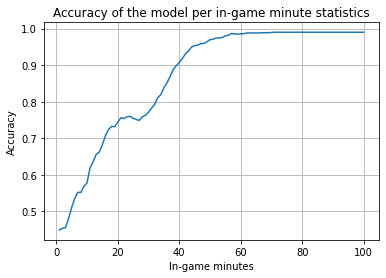

In [37]:
losses = []
accuracies = []
minutes = list(range(1, 96))
for available_steps in minutes:
    loss, accuracy = model.evaluate(test_set_generator(available_steps))
    losses.append(loss)
    accuracies.append(accuracy)

plt.plot(minutes, accuracies)
plt.grid()
plt.title('Accuracy of the model per in-game minute statistics')
plt.xlabel('In-game minutes')
plt.ylabel('Accuracy')
plt.show()

3/3 [==============================] - 0s 4ms/step - loss: 0.4964 - accuracy: 0.6667


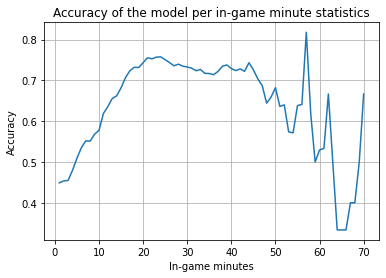

In [40]:
losses = []
accuracies = []
minutes = list(range(1, 71))
for available_steps in minutes:
    loss, accuracy = model.evaluate(test_set_generator(available_steps, filter_finished_matches=True))
    losses.append(loss)
    accuracies.append(accuracy)

plt.plot(minutes, accuracies)
plt.grid()
plt.title('Accuracy of the model per in-game minute statistics')
plt.xlabel('In-game minutes')
plt.ylabel('Accuracy')
plt.show()